## Метрики в задаче классификации

In [243]:
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns

sns.set("notebook", style="whitegrid", font_scale=1.3, palette="muted")
RANDOM_STATE = 42

Здесь описаны вспомогательные функции, что будут использоваться далее для красивого оформления. С ними можно будет ознакомиться отдельно

In [244]:
def highlight_best(series: pd.Series) -> List[str]:
    """
    Подсвечивает лучшие значения в столбце:
    - минимальные для времени;
    - максимальные для метрик.
    Игнорирует столбец 'Модель' и строковые 'nan'.

    Возвращает:
    - Список CSS-стилей для каждой ячейки.
    """
    if series.name == "Модель":
        return [""] * len(series)

    # Преобразование к числам, замена строковых 'nan'
    try:
        numeric_series = pd.to_numeric(series.replace(["nan", "NaN"], np.nan))
    except Exception:
        return [""] * len(series)

    if numeric_series.isnull().all():
        return [""] * len(series)

    # Выбор лучшего значения
    best_value = (
        numeric_series.min()
        if series.name in ["fit time, s", "pred time, s"]
        else numeric_series.max()
    )
    return ["background-color: lightgreen" if val == best_value else "" for val in numeric_series]

In [245]:
def visualize_metric_df(df: pd.DataFrame, precision: int = 4) -> Styler:
    """
    Визуализирует таблицу метрик с округлением, чёрными рамками и подсветкой лучших значений.

    Параметры:
    - df: DataFrame с метриками
    - precision: количество знаков после запятой

    Возвращает:
    - pandas Styler: стилизованная таблица
    """
    df_rounded = df.copy()
    numeric_cols = df_rounded.select_dtypes(include=["float64", "int64"]).columns

    df_rounded[numeric_cols] = df_rounded[numeric_cols].astype(float).round(precision)
    for col in numeric_cols:
        df_rounded[col] = df_rounded[col].apply(lambda x: f"{x:.{precision}f}")

    return df_rounded.style.set_table_styles(
        [{"selector": "td, th", "props": [("border", "1px solid black")]}]
    ).apply(highlight_best, axis=0)

Вы уже встречали различные метрики для задачи регрессии, теперь посмотрим на задачу классификации

**"Мир котиков"** — это многопользовательская онлайн-игра от компании **KittenGames**, где игроки управляют собственным виртуальным котом в открытом мире. Игроки могут исследовать города, выполнять квесты, участвовать в мини-играх (например, охота на мышей или боулинг с клубками), строить уютные дома, кастомизировать внешность кота и заводить друзей. За активность они получают внутриигровую валюту — **мяукоины**, которую можно тратить на предметы, еду, одежду и даже редких питомцев.

Однако в последнее время в игре стало появляться всё больше игроков, у которых подозрительно много мяукоинов при крайне низком времени в игре — и наоборот. Это сигнализирует о возможном использовании читов, багов или ботов.

KittenGames собрали базу по всем активным игрокам, в которой для каждого указано **количество накопленных мяукоинов** и **время, проведённое в игре** (в часах). Теперь перед аналитиками стоит задача — на основе этих данных построить модель, которая поможет автоматически выявлять подозрительные аккаунты, играющих нечестно.


### 1. Данные

Загрузим данные

In [246]:
import numpy as np

def generate_poisson_dataset(
    n_samples=1000, 
    random_state=43,
    beta_1_cheater=0.010,
    beta_1_non_cheater=0.005,
    multiplier_cheater=30,
    multiplier_non_cheater=5
):
    """
    Генерирует датасет с двумя фичами и двумя классами используя пуассоновскую регрессию.
    
    Класс 0 - обычные игроки (95%)
    Класс 1 - читеры (5%)
    
    Parameters:
    -----------
    n_samples : int
        Количество образцов
    random_state : int
        Seed для воспроизводимости
    beta_1_cheater : float
        Коэффициент наклона (slope) для читеров в пуассоновской регрессии
    beta_1_non_cheater : float
        Коэффициент наклона (slope) для обычных игроков в пуассоновской регрессии
    multiplier_cheater : float
        Множитель для значений мядукойнов читеров
    multiplier_non_cheater : float
        Множитель для значений мядукойнов обычных игроков
        
    Returns:
    --------
    X : numpy.ndarray
        Массив с двумя фичами, shape (n_samples, 2)
    y : numpy.ndarray
        Массив с метками классов (0 или 1), shape (n_samples,)
    """
    np.random.seed(random_state)
    
    # Определяем количество читеров (5%) и обычных игроков (95%)
    n_cheaters = int(n_samples * 0.065)
    n_normal = n_samples - n_cheaters
    
    # Создаем метки классов
    y = np.concatenate([np.zeros(n_normal), np.ones(n_cheaters)])
    
    # Генерируем первую фичу (время проведенное в игре)
    # Одинаковое нормальное распределение для всех
    # Центр в 200, std = 100
    feature1 = np.concatenate([np.random.normal(175, 100, n_normal), np.random.normal(175, 100, n_cheaters)]) 
    feature1 = np.clip(feature1, 0, 400)  # ограничиваем диапазон
    
    # Генерируем вторую фичу (мядукойны) из распределения Пуассона
    feature2 = np.zeros(n_samples)
    
    # beta_0 = 0 для всех
    beta_0 = 0
    
    # Для обычных игроков (класс 0)
    lambda_normal = beta_1_non_cheater * ( feature1[: n_normal] / 400)**(2) * 400
    feature2[:n_normal] = lambda_normal + (np.random.poisson(lambda_normal)-lambda_normal) * multiplier_non_cheater
    
    # Домножаем на 2 для не-читеров с feature1 < 50
    mask_low_time = feature1[:n_normal] < 50
    feature2[:n_normal][mask_low_time] *= 1

    # Для читеров (класс 1)
    lambda_cheater =  beta_1_cheater * ( feature1[n_normal:] / 400)**(2) * 400
    feature2[n_normal:] = lambda_cheater + (np.random.poisson(lambda_cheater) - lambda_cheater)  * multiplier_cheater
    
    # Перемешиваем данные
    shuffle_idx = np.random.permutation(n_samples)
    feature1 = feature1[shuffle_idx]
    feature2 = feature2[shuffle_idx]
    y = y[shuffle_idx]
    
    # Создаем numpy array
    X = np.column_stack([feature1, feature2])
    
    return X, y


In [247]:
# data = pd.read_csv("data_best.csv")
# data.head()

# X = data.iloc[:, :2].values
# y = data.is_cheater

X, y = generate_poisson_dataset(beta_1_cheater=25000.0/400,
    beta_1_non_cheater=8000.0/400,
    multiplier_cheater=100,
    multiplier_non_cheater=30)

Разделим их и визуализируем обучающую часть

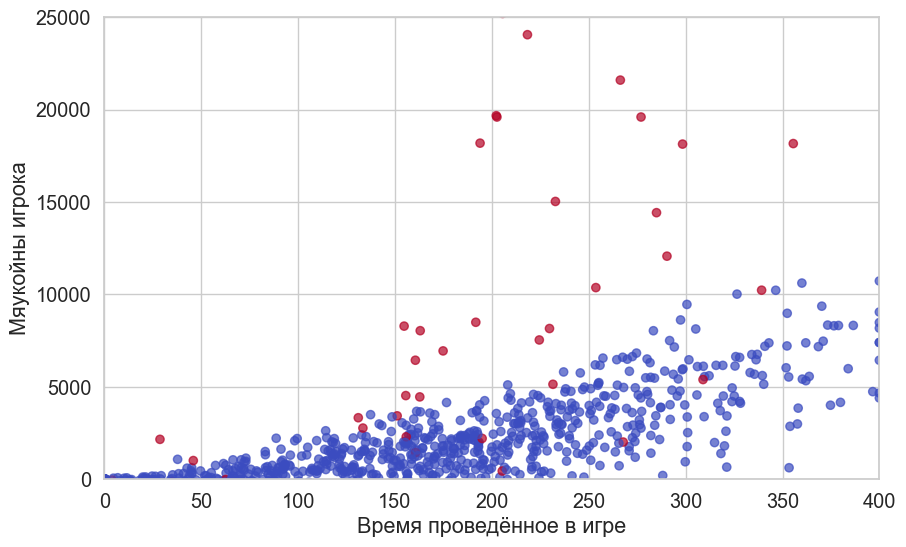

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 6))
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap="coolwarm",
    alpha=0.7,
)
plt.ylabel("Мяукойны игрока"), plt.xlabel("Время проведённое в игре")
plt.xlim(0, 400)
plt.ylim(0, 25000)
plt.show()

### 2. Модели

Попробуем решить задачу разными методами и выбрать лучший.
Для этого рассмотрим несколько известных нам моделей:
1. **Линейная регрессия с округлением предсказаний.**

2. **Логистическая регрессия**

3. **Дерево**

4. **Среднее / Самый частый класс**

5. **Всегда читер** &mdash; всегда выдаем $\widehat{y} = 1$.

6. **Всегда не читер** &mdash; всегда выдаем $\widehat{y} = 0$.

Обучим каждую из моделей

In [249]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
linear_prediction = (model_linear.predict(X_test) > 0.5) * 1

model_logistic = LogisticRegression(random_state=RANDOM_STATE)
model_logistic.fit(X_train, y_train)
logistic_prediction = model_logistic.predict(X_test)

model_tree = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
model_tree.fit(X_train, y_train)
tree_prediction = model_tree.predict(X_test)

mean_prediction = np.full(y_test.shape, (y_train.mean() > 0.5) * 1)

cheater_prediction = np.full(y_test.shape, 1)
not_cheater_prediction = np.full(y_test.shape, 0)

И сохраним их предсказания на тестовой выборке

In [250]:
predictions = [
    linear_prediction,
    logistic_prediction,
    tree_prediction,
    mean_prediction,
    cheater_prediction,
    not_cheater_prediction,
]
names = ["Linear", "Logistic", "Tree", "Mean", "All Cheater", "All Not Cheater"]

result_df = pd.DataFrame({"Модель": names})

### 3. Accuracy (доля правильных ответов)

[Accuracy в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Мы уже знаем эту метрику так что посмотрим качество наших моделей и сравним их.

In [251]:
accuracy = []
for y_pred in predictions:
    accuracy.append(accuracy_score(y_test, y_pred))
result_df["Accuracy"] = accuracy

visualize_metric_df(result_df, 3)

,Модель,Accuracy
0,Linear,0.940
1,Logistic,0.945
2,Tree,0.970
3,Mean,0.935
4,All Cheater,0.065
5,All Not Cheater,0.935


Модель "All not cheater" показывает качество 93,5%. Это происходит из-за несбалансированности классов. Чуть лучшее качество показывает линейная регрессия. Лучшее `accuracy` достигается с помощью логистической регрессии.


Пока что запомним, что лучше всего **логистическая регрессия**.
Но давайте поговорим в целом о метриках. Мы можем сравнивать модели иначе.

### 4. Confusion matrix (матрица ошибок)

[Confusion matrix в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)


**Confusion Matrix** (матрица ошибок) — это таблица, которая показывает, **как модель классификации справилась с предсказаниями**, сравнивая их с истинными значениями. Особенно полезна при **бинарной классификации** (например, «читер / не читер»), но может быть расширена и на многоклассовый случай.

Для начала разберемся с тем, какие исходы работы модели возможны.

Модель может сделать верные (**True**) предсказания:
* <font color="green"><b>True Positive (TP)</b></font> — количество объектов класса ***Positive***, для которых модель правильно предсказала класс ***Positive***.
* <font color="green"><b>True Negative (TN)</b></font> — количество объектов класса ***Negative***, для которых модель правильно предсказала класс ***Negative***.

Модель может сделать ошибочные (**False**) предсказания:
* <font color="red"><b>False Positive (FP)</b></font> — количество объектов класса ***Negative***, для которых модель предсказала класс ***Positive***.
* <font color="red"><b>False Negative (FN)</b></font> — количество объектов класса ***Positive***, для которых модель предсказала класс ***Negative***.

Все эти 4 типа собираются в одну таблицу, которая и называется Confusion Matrix

<table border="1" style="border-collapse: collapse;">
    <tr>
        <th style="border-bottom: 2px solid black; border-right: 2px solid black;"></th>
        <th style="border-bottom: 2px solid black; text-align: left;"><font size="3">Предсказано: Negative</font></th>
        <th style="border-bottom: 2px solid black; text-align: left;"><font size="3">Предсказано: Positive</font></th>
    </tr>
    <tr>
        <th style="border-right: 2px solid black; text-align: left;"><font size="3">Истинное: Negative</font></th>
        <td style="text-align: left;"><font size="3" color="green"><b>True Negative (TN)</b></font></td>
        <td style="text-align: left;"><font size="3" color="red"><b>False Positive (FP)</b></font></td>
    </tr>
    <tr>
        <th style="border-right: 2px solid black; text-align: left;"><font size="3">Истинное: Positive</font></th>
        <td style="text-align: left;"><font size="3" color="red"><b>False Negative (FN)</b></font></td>
        <td style="text-align: left;"><font size="3" color="green"><b>True Positive (TP)</b></font></td>
    </tr>
</table>

Confusion Matrix представляет собой основу для вычисления более точных метрик. Матрица помогает понять не просто, сколько предсказаний были верными, а **где именно модель ошибается** — путает ли классы между собой, и в каком направлении.

&#x2753; **Вопрос** &#x2753;


> Например, в данной терминологии $Accuracy$ можно представить через <font color="green"><b>TN</b></font>, <font color="green"><b>TP</b></font>, <font color="red"><b>FP</b></font>, <font color="red"><b>FN</b></font>. Выпишите формулу.


<details>
 <summary> Ответ </summary>
 $$Accuracy = \frac{\color{green}{\textbf{TP}} + \color{green}{\textbf{TN}}}{\color{green}{\textbf{TP}} + \color{green}{\textbf{TN}} + \color{red}{\textbf{FP}} + \color{red}{\textbf{FN}}}$$
</details><br/>

**Пример вычисления**

Вычислим матрицу ошибок для нашей задачи для логистической регрессии:

In [253]:
matrix = confusion_matrix(y_test, logistic_prediction)

pd.DataFrame(
    matrix,
    columns=["Predict Negative", "Predict Positive"],
    index=["Actual Negative", "Actual Positive"],
)

,Predict Negative,Predict Positive
Actual Negative,187,0
Actual Positive,11,2


**Вывод:**

Логистическая регрессия правильно нашла 7 читеров. Ещё 6 упустила. А также посчитала неверно читером ещё одного человека...

### 5. Precision (точность)

[Precision в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

> **Точность** (Precision, Positive Predictive Value) показывает какой процент объектов, которые модель оценила как ***Positive***, действительно являются объектами класса ***Positive***:
>
> $$Precision = \frac{\color{green}{\textbf{TP}}}{\color{green}{\textbf{TP}} + \color{red}{\textbf{FP}}}$$
>
> Иначе говоря, метрика показывает, *насколько часто модель верно говорит **Positive***.

**Достоинство**: позволяет следить за тем, насколько можно доверять модели, если она предсказывает класс ***Positive***.

**Недостаток**: не позволяет следить за тем, как много объектов класса ***Positive*** способен распознать классификатор.

Например, мы построили модель, которая присваивает класс ***Positive*** очень малому количеству объектов. Значение метрики $Precision$ у такой модели может быть достаточно высоким, но при этом модель будет присваивать класс ***Negative*** очень большому количеству объектов класса ***Positive***.

**Пример вычисления**

Вычислим $Precision$ для нашей задачи:

In [254]:
precision = []
for y_pred in predictions:
    precision.append(precision_score(y_test, y_pred))
result_df["Precision"] = precision

visualize_metric_df(result_df, 3)

/Users/ovcharov-s-d/venv-yt/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ovcharov-s-d/venv-yt/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Модель,Accuracy,Precision
0,Linear,0.940,1.000
1,Logistic,0.945,1.000
2,Tree,0.970,1.000
3,Mean,0.935,0.000
4,All Cheater,0.065,0.065
5,All Not Cheater,0.935,0.000


>_Замечание: Для моделей "Mean" и "All Not Cheater" нет **Positive** предсказаний. Поэтому происходит деление на 0, о чём и сообщает `UndefinedMetricWarning`_

Можно видеть, что самая точная модель &mdash; Линейная модель. То есть 100% читеров, что она нашла, &mdash; действительно читеры. Для логистической регрессии только 87,5% верно найденных читеров. И чуть менее точно дерево. Только 72,7% предполагаемых читеров действительно ими являются.

### 6. Recall (полнота)

[Recall в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

> **Полнота** (Recall, True Positive Rate) показывает какую долю объектов класса ***Positive*** модель классифицировала правильно:
>
> $$Recall = \frac{\color{green}{\textbf{TP}}}{\color{green}{\textbf{TP}} + \color{red}{\textbf{FN}}}$$


**Достоинство**: позволяет следить за тем, как много объектов класса ***Positive*** способен распознать классификатор.

**Недостаток**: не позволяет следить за тем, насколько можно доверять модели, если она предсказывает класс ***Positive***.

**Пример вычисления**

Вычислим $Recall$ для нашей задачи:

In [255]:
recall = []
for y_pred in predictions:
    recall.append(recall_score(y_test, y_pred))
result_df["Recall"] = recall

visualize_metric_df(result_df, 3)

,Модель,Accuracy,Precision,Recall
0,Linear,0.940,1.000,0.077
1,Logistic,0.945,1.000,0.154
2,Tree,0.970,1.000,0.538
3,Mean,0.935,0.000,0.000
4,All Cheater,0.065,0.065,1.000
5,All Not Cheater,0.935,0.000,0.000


А здесь уже обратная ситуация. Из всех читеров линейная модель нашла только 15,4%, но как мы помним зато они все точно читеры. Логистическая регрессия находит только примерно половину читеров. А дерево 61,5%, но вместе с тем задевает невиновных.

Также ожидаемо модель, что называет всех читерами, нашла всех читеров. Но вряд ли это подходит заказчику.


### 7. Precision vs Recall

Наглядная визуализация сравнения метрик $Precision$ и $Recall$

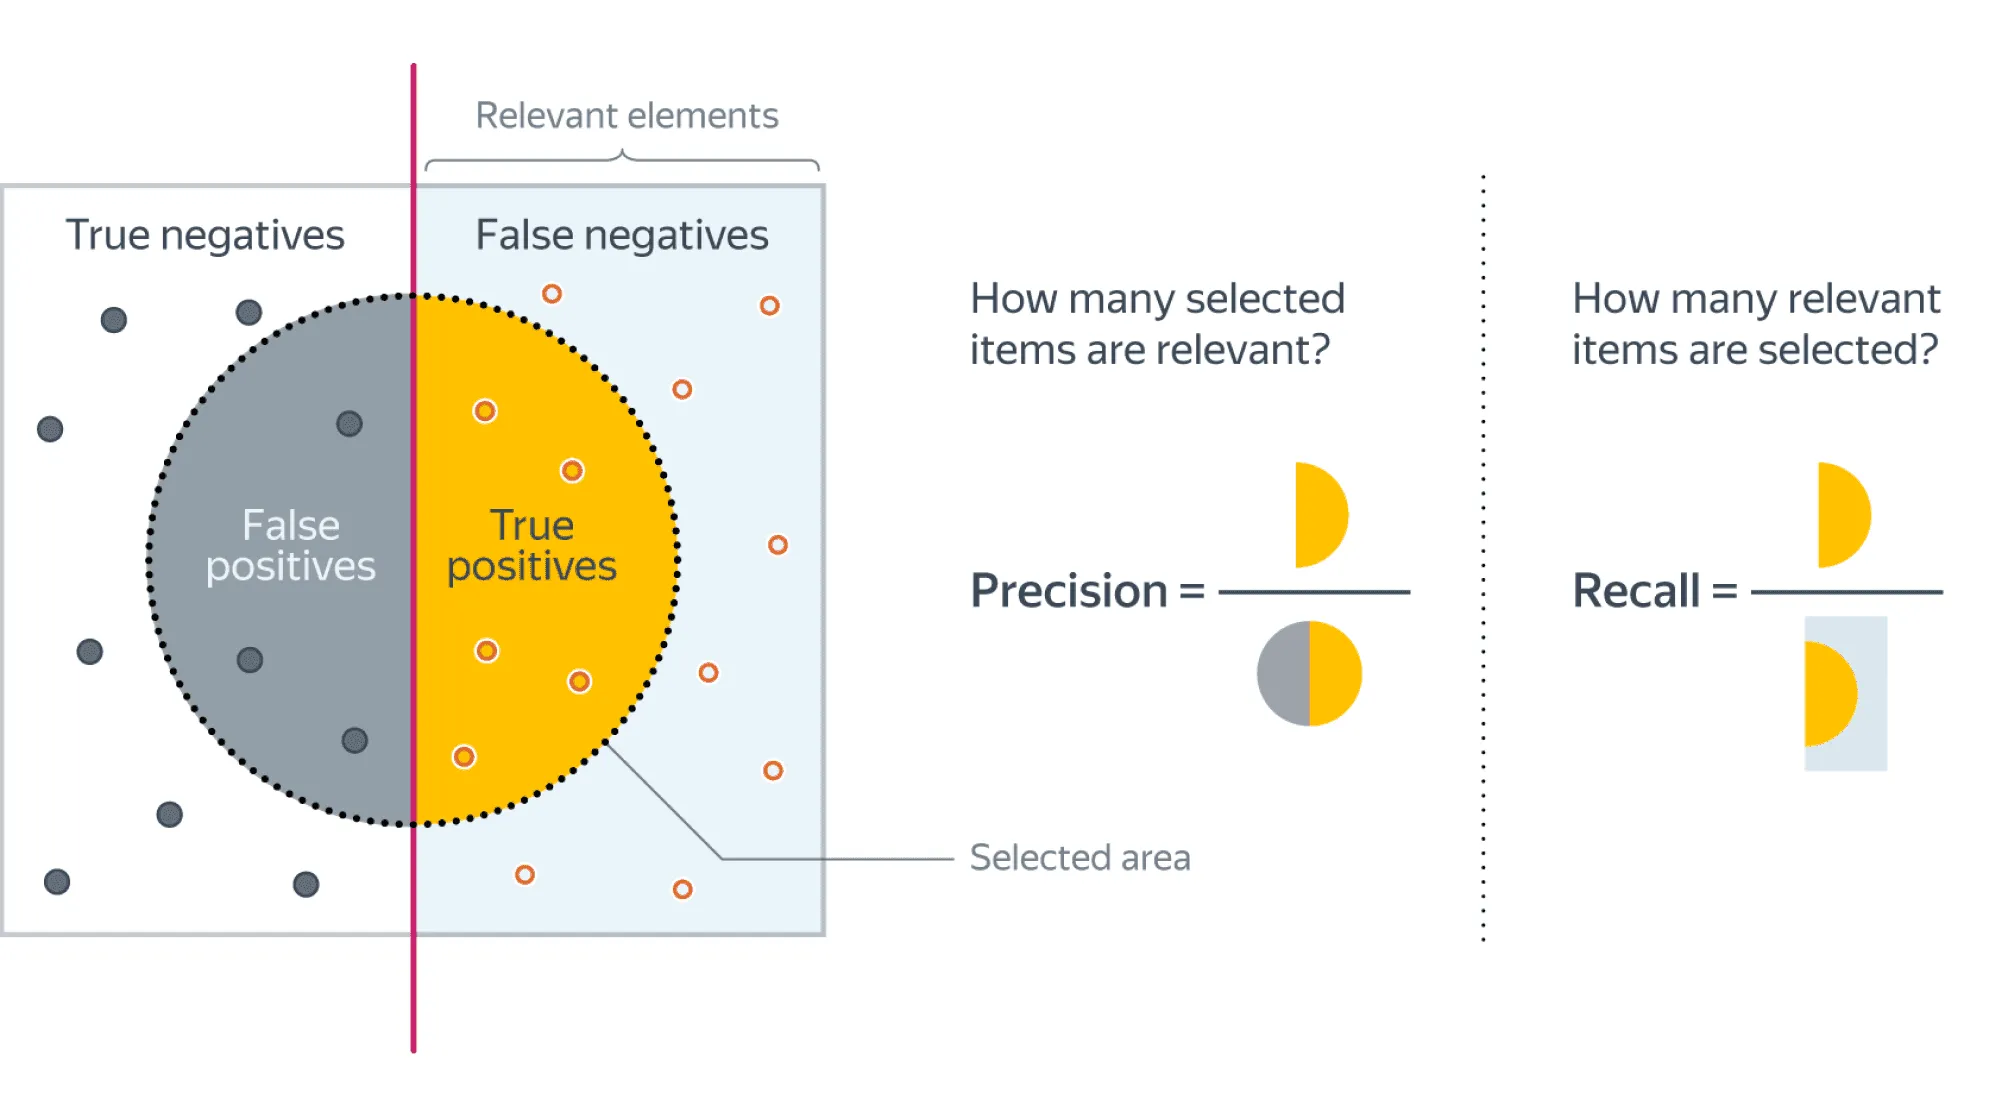

*Замечание 1.*

1. Легко построить модель с $Recall = 1$. Она все объекты относит к классу ***Positive***, но при этом $Precision$ может быть очень низким.
2. Нетрудно построить модель с $Precision$ близким к $1$. Она относит к классу ***Positive*** только те объекты, в которых точно уверена, при этом $Recall$ может быть низким.

*Замечание 2.*

Отметим, что точность и полнота *не зависят от соотношения размеров классов*. Даже если объектов класса ***Positive*** на порядки меньше, чем объектов класса ***Negative***, данные показатели будут корректно отражать качество работы модели.


&#x2753; **Вопрос** &#x2753;


> Больница хочет использовать ИИ! Нужно по флюорографии определять, есть ли у человека турбекулёз. На какую метрику стоит ориентироваться при оценке качества модели?


<details>
 <summary> Ответ </summary>

Снача определим, что мы хотим минимизировать. В случае турбекулёза явно важнее отправить человека на дополнительные анализы, чем не диагностировать заболевание. То есть мы хотим минимизировать в первую очередь FN. Тогда будем ориентироваться на `recall`. А при равном `recall` уже можно использовать `presicion`, чтобы минимизировать число ложных срабатываний
</details><br/>


&#x2753; **Вопрос** &#x2753;


> Перед нами стоит задача: фильтровать почту на предмет спама. Какую метрику выберем при оценке модели?


<details>
 <summary> Ответ </summary>

В данном случае нам важно не пропустить важное письмо. Спам пользователь и визуально может отличить, а вот проверять папку спам, чтобы найти подтверждение подписки &mdash; уже неприятно. Так что будем минимизировать FP. Тогда в этом случае нам вполне подойдёт `presicion`. В случае если спам писем пропорционально много, то подойдёт и `accuracy`
</details><br/>


### 8. $F_1$-мера
[$F_1$-мера в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Хотелось бы получить один критерий, который учитывал бы в себе и точность, и полноту. Существует несколько способов получить один критерий качества на основе точности и полноты.
> Один из них &mdash; **$F_1$-мера**, гармоническое среднее точности и полноты:
>
> $$F_1 = \frac{ 2 \cdot Precision \cdot Recall}{Precision + Recall}$$
>
Среднее гармоническое обладает важным свойством &mdash; оно близко к нулю, если хотя бы один из аргументов близок к нулю.
При этом $F_1$ достигает максимума при $Precision = 1$ и $Recall = 1$.

*Замечание.*

Иногда эту метрику просто называют $F$-мерой.

**Пример вычисления**

Вычислим $F_1$-меру для нашей задачи:

In [256]:
f1 = []
for y_pred in predictions:
    f1.append(f1_score(y_test, y_pred))
result_df["F1"] = f1

visualize_metric_df(result_df, 3)

,Модель,Accuracy,Precision,Recall,F1
0,Linear,0.940,1.000,0.077,0.143
1,Logistic,0.945,1.000,0.154,0.267
2,Tree,0.970,1.000,0.538,0.700
3,Mean,0.935,0.000,0.000,0.000
4,All Cheater,0.065,0.065,1.000,0.122
5,All Not Cheater,0.935,0.000,0.000,0.000


При агрегации получаем, что лучшие модели это дерево и логистическая регрессия. Какую из них мы выберем? Зависит от того, насколько мы хотим избегать несправедливых блокировок. Дерево найдёт больше читеров, а Логистическая регрессия найдёт меньше, но и при этом меньше невиновных заденет

### 9. Сравнение агрегации

Рассмотрим другие методы агрегации $Precision$ и $Recall$. Они не используются, но полезно увидеть их недостатки в сравнении со средним гармоническим. <br>

**1.** **Среднее арифметическое**

$A = \frac{Precision + Recall}{2}$ <br>

  **Недостатки:** <br>
  Пусть есть выборка, в которой $10\%$ объектов &mdash; класс ***Positive***. <br>
  * Модель $y_1$ всегда выдает класс ***Positive***
  
    $\Rightarrow Precision_{1} = 0.1, Recall_{1} = 1$
    
    $\Rightarrow A_1 = 0.55$ <br><br>

  * Модель $y_2$ имеет $Precision_{2} = 0.55, Recall_{2} = 0.55$ <br>

    $\Rightarrow A_2 = 0.55$ <br>
  Среднее арифметическое обеих моделей одинаково, однако первая модель совсем бесполезная, а вторая хоть как-то умеет различать классы. <br> <br>


**2.** **Минимум**

$M = \min(Precision, Recall)$<br>

  **Недостатки:** <br>

  * Модель $y_1$ имеет $Precision_{1} = 0.4, Recall_{1} = 0.9$ <br>

      $\Rightarrow M_1 = 0.4$ <br><br>

  * Модель $y_2$ имеет $Precision_{2} = 0.4, Recall_{2} = 0.5$ <br>

      $\Rightarrow M_2 = 0.4$ <br><br>

    Минимумы двух моделей одинаковы, однако очевидно, что первая модель гораздо лучше.

Визуализируем различные методы агрегации $Precision$ и $Recall$.

In [257]:
precision_grid = np.linspace(0, 1, 1000)[1:]
recall_grid = np.linspace(0, 1, 1000)[1:]
precision_mesh, recall_mesh = np.meshgrid(precision_grid, recall_grid)
mean_values = (precision_mesh + recall_mesh) / 2
min_values = np.minimum(precision_mesh, recall_mesh)
f1_values = 2 * precision_mesh * recall_mesh / (precision_mesh + recall_mesh)

levels = np.linspace(0, 1, 25)

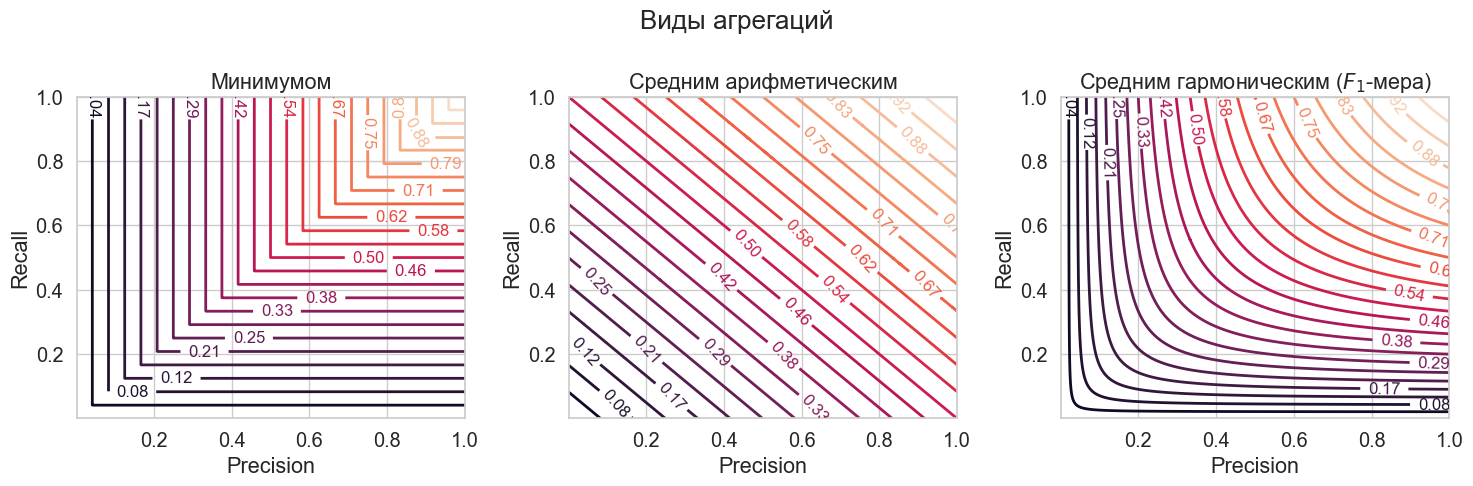

In [258]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
clabel = plt.contour(precision_grid, recall_grid, min_values, levels=levels, linewidths=2)
plt.clabel(clabel, inline=True, fontsize=12, fmt="%0.2f")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Минимумом")

plt.subplot(1, 3, 2)
clabel = plt.contour(precision_grid, recall_grid, mean_values, levels=levels, linewidths=2)
plt.clabel(clabel, inline=True, fontsize=12, fmt="%0.2f")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Средним арифметическим")

plt.subplot(1, 3, 3)
clabel = plt.contour(precision_grid, recall_grid, f1_values, levels=levels, linewidths=2)
plt.clabel(clabel, inline=True, fontsize=12, fmt="%0.2f")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Средним гармоническим ($F_1$-мера)")

plt.suptitle("Виды агрегаций")
plt.tight_layout()
plt.show()

Можно заметить, что $F_1$-мера по сути является сглаженной версией минимума из точности и полноты, и поэтому она лишена минусов двух рассмотренных метрик.

### 10. Практика

&#x2753; **Вопрос 3** &#x2753;


> Под конец рабочего дня пришёл клиент. Предлагает большие деньги. Это "ВжухЗайм".
>
> **Задача:** по данным клиента определить, стоит ли ему звонить, чтобы он оформил ещё один кредит. Время деньги, напоминает заказчик, так что решение должно быть скоро


<details>
 <summary> Ответ </summary>

Прежде всего у нас бывает две неприятные ситуации:

1. Мы позвонили, но человек отказался. Тогда фирма потратила время и потеряла потенциальную прибыль, т.к. могли потратить это время на другого. Это случай <font color="red"><b>FP</b></font>.

2. Мы не позвонили человеку, а он вообще готов согласиться. Это случай <font color="red"><b>FN</b></font>.
Причём заметим, что в каждом случае мы теряем разное количество прибыли. В первом случае &mdash; это средний заработок за потраченное время. Во-втором, средняя прибыль с кредита

Можно предложить два подхода:

1. $F_1$-score. Просто балансируем между этими двумя случаями

2. Точно подсчитываем прибыль, и берём взвешенное среднее `presicion` и `recall` с данными коэффициентами.
</details><br/>



## Заключение

Мы рассмотрели метрики для сравнения моделей в задаче классификации и на практике посмотрели, какие метрики лучше подходят под какие задачи.

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД